In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
seed = 1
img_h = 100
img_w = 100
batch_size = 32
data_dir = 'FotoAI2020'

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.3,
    subset='training',
    batch_size=batch_size,
    color_mode='grayscale',
    image_size=(img_h, img_w),
    seed=seed
)

Found 420 files belonging to 43 classes.
Using 294 files for training.


In [3]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.3,
    subset='validation',
    batch_size=batch_size,
    color_mode='grayscale',
    image_size=(img_h, img_w),
    seed=seed
)

Found 420 files belonging to 43 classes.
Using 126 files for validation.


In [4]:
classes = train_set.class_names
print(classes)

['AAA', 'ABI', 'AFI', 'AGH', 'AIL', 'ARL', 'ASA', 'BDL', 'DIA', 'DIO', 'DRA', 'EZA', 'FAR', 'FMR', 'FRS', 'GLA', 'GPS', 'HMA', 'HZR', 'IDR', 'KDA', 'MAA', 'MAJ', 'MFA', 'MFH', 'MGN', 'MMF', 'MRF', 'MSA', 'MZA', 'MZB', 'NIS', 'QTH', 'RCK', 'RKS', 'SAD', 'SHE', 'SNN', 'SVD', 'SYH', 'SYN', 'YSS', 'ZHT']


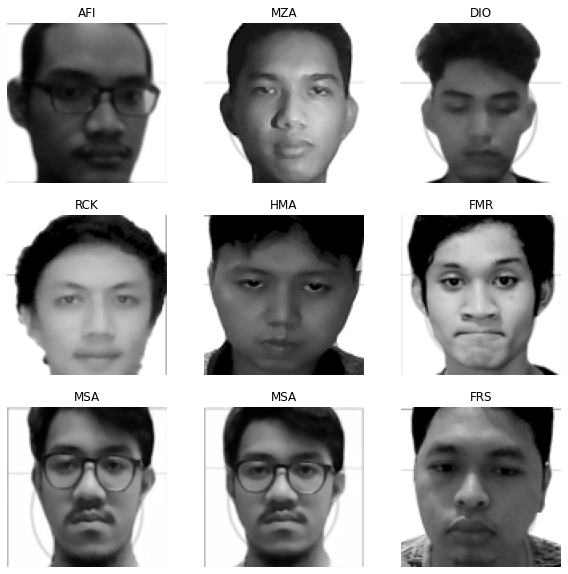

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(classes[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 1)
(32,)


In [7]:
train_set = train_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
normalized_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
num_classes = 43

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

In [13]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch, time.time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch (sec)')
        plt.plot(*zip(*self.times))
        plt.show()
        print('Total Time to Epoch ', self.times[-1][0], ': ', self.times[-1][1], ' Seconds')

Epoch 1/20
10/10 [==============================] - 1s 97ms/step - loss: 3.7431 - accuracy: 0.0238 - val_loss: 3.7004 - val_accuracy: 0.0556
Epoch 2/20
10/10 [==============================] - 1s 79ms/step - loss: 3.4921 - accuracy: 0.1122 - val_loss: 3.3209 - val_accuracy: 0.2302
Epoch 3/20
10/10 [==============================] - 1s 85ms/step - loss: 2.6547 - accuracy: 0.3946 - val_loss: 2.2212 - val_accuracy: 0.4683
Epoch 4/20
10/10 [==============================] - 1s 81ms/step - loss: 1.3532 - accuracy: 0.7415 - val_loss: 1.0798 - val_accuracy: 0.7460
Epoch 5/20
10/10 [==============================] - 1s 80ms/step - loss: 0.4821 - accuracy: 0.8639 - val_loss: 0.7197 - val_accuracy: 0.8016
Epoch 6/20
10/10 [==============================] - 1s 72ms/step - loss: 0.2163 - accuracy: 0.9490 - val_loss: 0.5398 - val_accuracy: 0.8413
Epoch 7/20
10/10 [==============================] - 1s 76ms/step - loss: 0.1252 - accuracy: 0.9694 - val_loss: 0.4469 - val_accuracy: 0.8810
Epoch 8/20
10

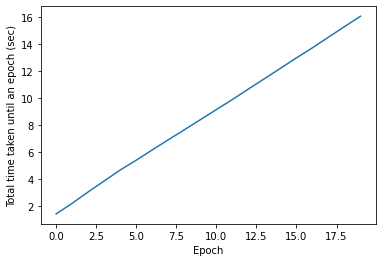

Total Time to Epoch  19 :  16.07865619659424  Seconds


In [14]:
epochs = 20
timetaken = timecallback()
history = model.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs,
  callbacks=[timetaken]
)

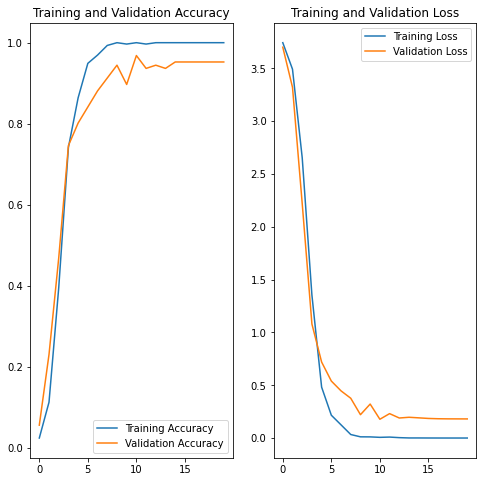

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# simpan hasil akurasi untuk di plot
CNN_acc = (acc[-1], val_acc[-1])

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

BPNN

PCA

In [16]:
def tfds_to_numpy(ds):
    ret = None
    lab = None
    for image, label in tfds.as_numpy(ds):
        if (ret is None):
            ret = image
            lab = label
        else:
            ret = np.append(ret, image, axis=0)
            lab = np.append(lab, label)
    return ret, lab.flatten()

reshape2 = (lambda arr: arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2]))

x_train_np, y_train_np = tfds_to_numpy(train_set)
x_test_np, y_test_np = tfds_to_numpy(test_set)


x_train_np = reshape2(x_train_np)
x_test_np = reshape2(x_test_np)

print(x_train_np.shape)
print(y_train_np.shape)

(294, 10000)
(294,)


In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(x_train_np)
X_test_scaled = scaler.transform(x_test_np)

In [18]:
pca = PCA(n_components=100, whiten=True)
pca.fit(X_train_scaled)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)
pca_std = np.std(X_pca_train)

In [19]:
model = Sequential([
    keras.layers.Flatten(),
    keras.layers.GaussianNoise(pca_std),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=num_classes, activation='sigmoid')
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Epoch 1/20
10/10 [==============================] - 0s 14ms/step - loss: 3.8151 - accuracy: 0.0340 - val_loss: 3.6234 - val_accuracy: 0.1349
Epoch 2/20
10/10 [==============================] - 0s 3ms/step - loss: 3.4994 - accuracy: 0.1259 - val_loss: 3.4602 - val_accuracy: 0.1825
Epoch 3/20
10/10 [==============================] - 0s 3ms/step - loss: 3.2252 - accuracy: 0.2415 - val_loss: 3.2031 - val_accuracy: 0.4365
Epoch 4/20
10/10 [==============================] - 0s 3ms/step - loss: 2.7312 - accuracy: 0.4490 - val_loss: 2.8394 - val_accuracy: 0.5238
Epoch 5/20
10/10 [==============================] - 0s 3ms/step - loss: 2.2527 - accuracy: 0.5374 - val_loss: 2.3539 - val_accuracy: 0.6032
Epoch 6/20
10/10 [==============================] - 0s 3ms/step - loss: 1.6999 - accuracy: 0.6973 - val_loss: 1.8586 - val_accuracy: 0.7460
Epoch 7/20
10/10 [==============================] - 0s 3ms/step - loss: 1.3348 - accuracy: 0.7483 - val_loss: 1.4692 - val_accuracy: 0.8016
Epoch 8/20
10/10 [=

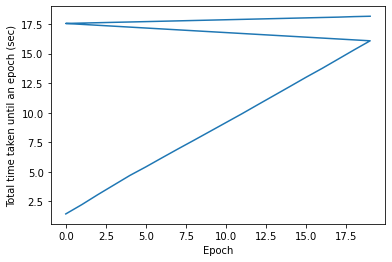

Total Time to Epoch  19 :  18.15459442138672  Seconds


In [21]:
history = model.fit(
    x=X_pca_train,
    y=y_train_np,
    validation_data=(X_pca_test, y_test_np),
    epochs=epochs,
    callbacks=[timetaken]
)

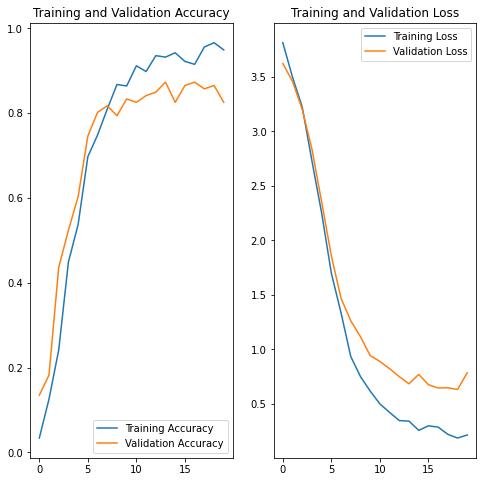

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# simpan hasil akurasi untuk di plot
BPNN_acc = (acc[-1], val_acc[-1])

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Mantap!

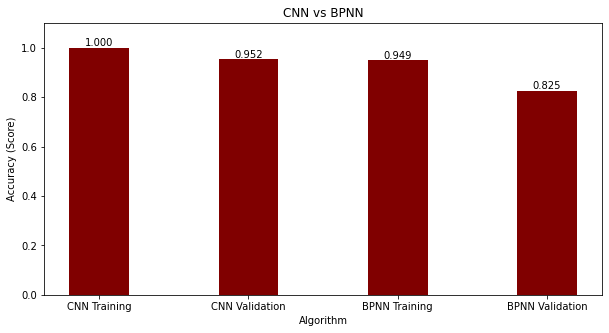

In [35]:
fig = plt.figure(figsize = (10, 5))

xloc = ['CNN Training', 'CNN Validation',
        'BPNN Training', 'BPNN Validation']
yloc = [CNN_acc[0], CNN_acc[1],
        BPNN_acc[0], BPNN_acc[1]]
 
# creating the bar plot
mybar = plt.bar(xloc, yloc, color ='maroon', width = 0.4)

# Add counts above the two bar graphs
for rect in mybar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')
 
plt.ylim(0.0, 1.1)
plt.xlabel("Algorithm")
plt.ylabel("Accuracy (Score)")
plt.title("CNN vs BPNN")
plt.show()